# Legends Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 26 # legends

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              265 non-null    int64  
 1   dimCustomerMasterId       265 non-null    int64  
 2   customerNumber            265 non-null    object 
 3   year                      265 non-null    object 
 4   productGrouping           265 non-null    object 
 5   totalSpent                265 non-null    float64
 6   recentDate                265 non-null    object 
 7   attendancePercent         265 non-null    float64
 8   renewedBeforeDays         265 non-null    int64  
 9   isBuyer                   265 non-null    object 
 10  source_tenure             265 non-null    int64  
 11  tenure                    265 non-null    int64  
 12  distToVenue               265 non-null    float64
 13  totalGames                265 non-null    int64  
 14  recency   

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          265 non-null    int64  
 1   dimCustomerMasterId   265 non-null    int64  
 2   customerNumber        265 non-null    object 
 3   year                  265 non-null    object 
 4   productGrouping       265 non-null    object 
 5   totalSpent            265 non-null    float64
 6   recentDate            265 non-null    object 
 7   attendancePercent     265 non-null    float64
 8   renewedBeforeDays     265 non-null    int64  
 9   isBuyer               265 non-null    object 
 10  source_tenure         265 non-null    int64  
 11  tenure                265 non-null    int64  
 12  distToVenue           265 non-null    float64
 13  totalGames            265 non-null    int64  
 14  recency               265 non-null    int64  
 15  missed_games_1        2

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (238, 47)
Unseen Data For Predictions: (27, 47)
Data for Modeling (A Class): (238, 47)
Unseen Data For Predictions: (27, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(265, 17)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  265 non-null    int64  
 1   totalSpent           265 non-null    float64
 2   attendancePercent    265 non-null    float64
 3   renewedBeforeDays    265 non-null    int64  
 4   source_tenure        265 non-null    int64  
 5   tenure               265 non-null    int64  
 6   distToVenue          265 non-null    float64
 7   recency              265 non-null    int64  
 8   missed_games_over_2  265 non-null    int64  
 9   isNextYear_Buyer     265 non-null    int64  
dtypes: float64(3), int64(7)
memory usage: 20.8 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [8]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,totalSpent,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_over_2,isNextYear_Buyer
dimCustomerMasterId,1.00,0.15,0.13,0.28,0.23,0.23,-0.15,-0.07,0.09,0.37
totalSpent,0.15,1.00,0.03,0.17,-0.02,-0.02,-0.01,-0.16,0.19,0.21
attendancePercent,0.13,0.03,1.00,0.06,0.13,0.13,-0.03,-0.38,0.35,-0.08
renewedBeforeDays,0.28,0.17,0.06,1.00,0.30,0.30,-0.03,0.13,0.01,0.31
source_tenure,0.23,-0.02,0.13,0.30,1.00,1.00,-0.10,0.20,-0.09,-0.14
tenure,0.23,-0.02,0.13,0.30,1.00,1.00,-0.10,0.20,-0.09,-0.14
distToVenue,-0.15,-0.01,-0.03,-0.03,-0.10,-0.10,1.00,0.03,-0.04,-0.15
recency,-0.07,-0.16,-0.38,0.13,0.20,0.20,0.03,1.00,-0.40,-0.05
missed_games_over_2,0.09,0.19,0.35,0.01,-0.09,-0.09,-0.04,-0.40,1.00,0.08
isNextYear_Buyer,0.37,0.21,-0.08,0.31,-0.14,-0.14,-0.15,-0.05,0.08,1.00


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [9]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (212, 10)
Unseen Data For Predictions: (53, 10)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [11]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=["totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "recency",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,7715
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(212, 10)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(False,
 None,
 StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
 'clf-default-name',
 Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False),
 Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['totalSpent',
                                                           'attendancePercent',
                                                           'renewedBeforeDays',
                                                           'source_tenure',
                                                           'tenure',
                                                           'distToVenue',
                                                    

In [12]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Ada Boost Classifier,0.7504,0.8089,0.7936,0.7956,0.7905,0.4790,0.4861,0.0320
5,Light Gradient Boosting Machine,0.7386,0.7945,0.8036,0.7798,0.7861,0.4446,0.4552,0.0130
9,Extreme Gradient Boosting,0.7272,0.8250,0.7845,0.7757,0.7771,0.4202,0.4291,0.1380
3,Extra Trees Classifier,0.7221,0.7970,0.8364,0.7485,0.7856,0.3906,0.4078,0.1760
2,Gradient Boosting Classifier,0.7210,0.8112,0.7964,0.7621,0.7707,0.4078,0.4302,0.0280
7,Random Forest Classifier,0.7154,0.8094,0.8345,0.7355,0.7784,0.3794,0.3967,0.1860
8,NGBClassifier,0.6864,0.7906,0.7864,0.7246,0.7525,0.3244,0.3300,0.2510
1,Decision Tree Classifier,0.6636,0.6420,0.7364,0.7281,0.7255,0.2828,0.2903,0.0050
4,K Neighbors Classifier,0.6382,0.6745,0.7336,0.6962,0.7040,0.2193,0.2276,0.0460
6,Logistic Regression,0.6096,0.6882,1.0000,0.6096,0.7571,0.0000,0.0000,0.0050


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [13]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8824,0.8636,1.0000,0.8462,0.9167,0.7213,0.7511
1,0.8235,0.8182,0.9091,0.8333,0.8696,0.5984,0.6039
2,0.7059,0.7879,0.7273,0.8000,0.7619,0.3796,0.3825
3,0.9412,0.9714,0.9000,1.0000,0.9474,0.8811,0.8874
4,0.8235,0.7857,0.9000,0.8182,0.8571,0.6277,0.6326
5,0.6471,0.8000,0.8000,0.6667,0.7273,0.2388,0.2469
6,0.7059,0.8143,0.7000,0.7778,0.7368,0.4056,0.4085
7,0.6471,0.6286,0.7000,0.7000,0.7000,0.2714,0.2714
8,0.7647,0.8857,0.8000,0.8000,0.8000,0.5143,0.5143
9,0.5625,0.7333,0.5000,0.7143,0.5882,0.1515,0.1627


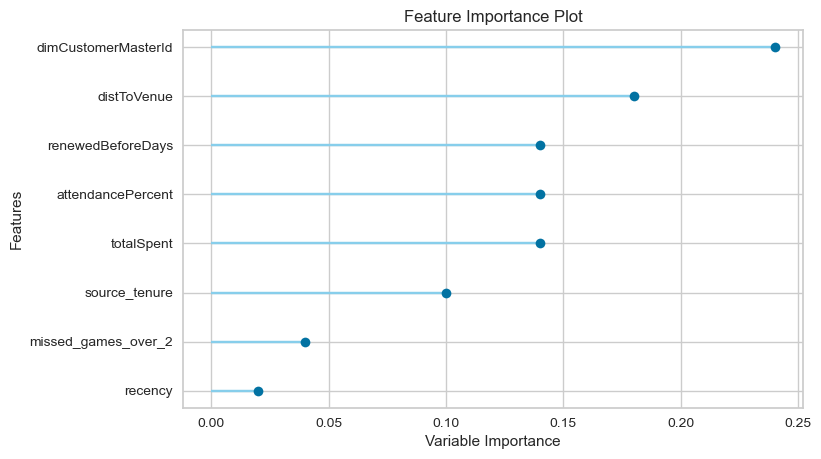

In [14]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?